# EEP 467 Homework 2: Breaking CAPTCHAs End-to-End

In lab 2, we have successfully built a pipeline that automatically recognizes CAPTCHAs. So far, the recognition process requires manually identifying contours (and subsequently bounding boxes) around characters using expert rules, before performing classification on extracted character images. This inspires us for possible further improvement: can we use a single neural network to directly identify CAPTCHA characters from CAPTCHA image? In this homework, we will get rid of bounding box identification and build an end-to-end neural network model.

## Before You Start

1. You can discuss on Discord if you have questions and want to seek help; however, please try your best to **limit the scope of your question** and **avoid asking directly for answers**. You should also **avoid copy-pasting answers and code** from others.
2. You are allowed to use AI assistants for help. In this case, you should **acknowledge your use of AI assistant** by providing its **name as well as how it helps you** to obtain your answer. Again, you **should not copy-paste from the response** of the AI assistant.

## Pre-processing

First of all, make sure you have installed all dependencies needed for this homework. The list of depedencies is similar to lab 3, except that we will ditch OpenCV and `imutils`, and instead use PyTorch Vision (`torchvision`) for some of our preprocessing work:

In [14]:
# %pip install matplotlib scikit-learn tqdm

# If using Anaconda / Miniconda, install PyTorch and PyTorch Vision with:
# %conda install conda-forge::pytorch-gpu conda-forge::torchvision # (CPU and GPU support)
# %conda install conda-forge::pytorch conda-forge::torchvision # (CPU-only support)

# If using Pip, install PyTorch and PyTorch Vision with:
%pip install torch torchvision
# When installing PyTorch with GPU support, refer to https://pytorch.org/get-started/locally/
# if your CUDA version differs from the default CUDA version of the current version PyTorch package.

Note: you may need to restart the kernel to use updated packages.


Once you are ready, we will start with data pre-processing step where we load all CAPTCHA images into memory. There are a few utilities in `torchvision` which can help us do the job:

In [15]:
import os

import torch
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.io import ImageReadMode, decode_image

# CAPTCHA images directory
CAPTCHA_IMAGES_DIR = "captcha-images"

# CAPTCHA images
captcha_images = []
# CAPTCHA texts
captcha_texts = []

## [ TODO ]
# 1) Load all CAPTCHA images from `CAPTCHA_IMAGES_DIR` into `captcha_images`
#    (Hint: use `os.scandir` to iterate over directory entries and check file extensions with `IMG_EXTENSIONS`)
#    (Hint: use `torchvision.io.decode_image` to load images in grayscale mode)
#    (Note: your code should ignore non-image files)
for captcha in os.scandir(CAPTCHA_IMAGES_DIR):
    captcha_images.append(decode_image(f'{CAPTCHA_IMAGES_DIR}/{captcha.name}', mode='GRAY'))
    captcha_texts.append(captcha.name.split('.')[0])

# 2) Stack all CAPTCHA images into a PyTorch tensor
# print(captcha_images[0].shape, captcha_images)
captcha_images = torch.stack(captcha_images)

# 3) Load all CAPTCHA texts (filenames without extension) into `captcha_texts`
#    (Items in `captcha_images` and `captcha_texts` should match)
pass

assert isinstance(captcha_images, torch.Tensor), "`captcha_images` must be a PyTorch tensor!"
assert captcha_images.ndim==4, "`captcha_images` should be a 4D tensor!"
assert captcha_images.shape[1:]==(1, 24, 72), "`captcha_images` should have shape (n_images, 1, h, w)!"

assert len(captcha_images)==len(captcha_texts), \
    "`captcha_images` should have the same number of elements as `captcha_texts`!"
assert all(isinstance(text, str) and len(text)==4 for text in captcha_texts), \
    "all `captcha_texts` should be strings with four letters!"

Then, we split all CAPTCHA images and texts into training-validation and test sets:

In [16]:
from sklearn.model_selection import train_test_split

# Training-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Split dataset into training and test sets
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

Next, we encode each character in the CAPTCHA text as class indices:

In [17]:
from sklearn.preprocessing import LabelEncoder
import hw2_util

# Label encoder
le = LabelEncoder()

## [ TODO ]
# 1) Flatten training-validation CAPTCHA texts into list of characters
#    (Hint: `hw2_util.flatten` can help you with that)
texts_flat_cv = list(hw2_util.flatten(captcha_texts_tv))

# 2) Fit and transform characters into class indices using `LabelEncoder`
class_indices_cv = le.fit_transform(texts_flat_cv)
class_indices_cv = torch.tensor(class_indices_cv)

# 3) Save number of classes (distinct characters) in `n_classes`
n_classes = len(le.classes_)

# 4) Convert class indices to PyTorch tensor and reshape as `texts_class_indices_tv`
#    (The shape of `texts_class_indices_tv` should be (n_images, 4))
texts_class_indices_tv = torch.reshape(class_indices_cv, (len(captcha_texts_tv), 4))

assert isinstance(texts_class_indices_tv, torch.Tensor), "`texts_class_indices_tv` must be a PyTorch tensor!"
assert texts_class_indices_tv.ndim==2, "`texts_class_indices_tv` must have two dimensions!"
assert texts_class_indices_tv.shape==(len(captcha_texts_tv), 4), \
    "Shape of `texts_class_indices_tv` should be (n_images, 4)!"

Then, we further split training-validation set into two parts:

In [18]:
# Split training set further into training and validation sets
captcha_images_train, captcha_images_vali, texts_class_indices_train, texts_class_indices_vali = train_test_split(
    captcha_images_tv, texts_class_indices_tv, test_size=0.25, random_state=TVT_SPLIT_SEED
)

## Data Augmentation

The following step will be unique to this homework: we will perform **data augmentation** using PyTorch's [`transforms.Compose`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) and [`transforms.RandomAffine`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.RandomAffine.html). Here we will configure the `RandomAffine` transform to **apply the following random effects** to our CAPTCHAs:

* Random rotation (at most 5 degrees)
* Random horizontal and vertical shifting (at most 10%)
* Random shearing (at most 5 degrees)
* Random zooming in or out (at most 10%)

Besides, we will also **pre-process the image pixels** in the `RescaleInvertPixels` custom transform. Here we need to first **rescale the grayscale values** to $[0, 1]$ range and then **invert the grayscales**. We will chain the `RescaleInvertPixels` transform together with the `RandomAffine` transform using `Compose` to create a complete augmentation pipeline.

Below code will create such a transform pipeline, and preview its effects on a few sample CAPTCHAs:

Figure(2000x500)
Figure(2000x500)


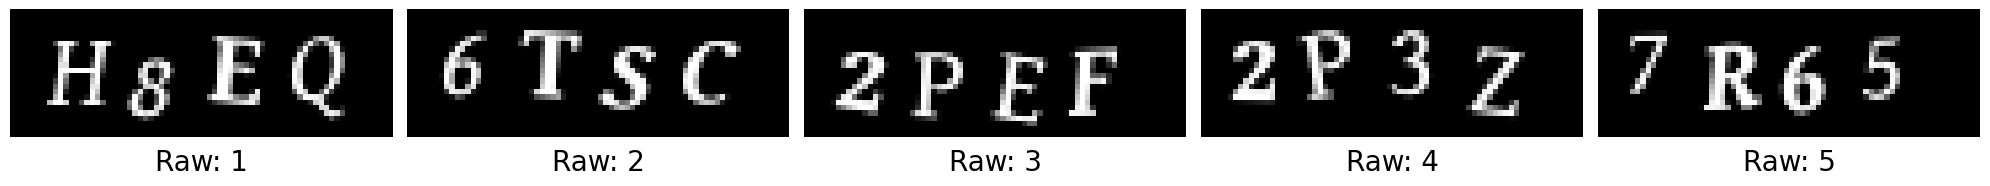

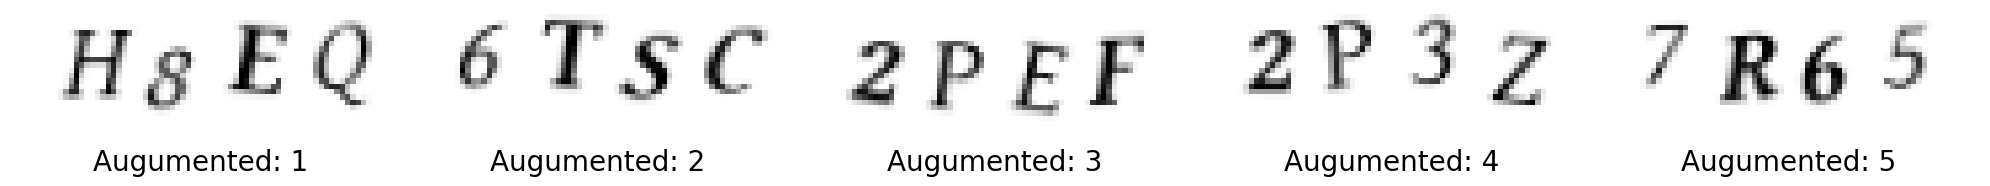

In [19]:
from torch import nn
from torchvision.transforms import Compose, InterpolationMode, RandomAffine

class RescaleInvertPixels(nn.Module):
    def forward(self, raw_image):
        ## [ TODO ]
        # 1) Rescale pixel grayscale values to [0, 1]
        image = raw_image - torch.min(raw_image)
        max_ = torch.max(image)

        image = image.to(torch.float32)

        if max_ != 0:
            image /= max_

        # 2) Invert the grayscales of the image (darker becomes lighter, and vice versa)
        image = 1 - image
        
        # 3) Return modified grayscales
        return image

## [ TODO ]
# Create a transform pipeline using `Compose` with:
# 1) `RescaleInvertPixels()` for preprocessing
# 2) `RandomAffine` with the following random effects:
#    - Rotation: at most 5 degrees
#    - Horizontal and vertical shift: at most 10%
#    - Zooming: at most 10% (scale between 0.9 and 1.1)
#    - Shearing: at most 5 degrees
#    - Use `InterpolationMode.BILINEAR` for interpolation
#
# Choose parameters such that CAPTCHAs are moderately distorted but still recognizable.
captcha_transform = Compose([
    RescaleInvertPixels(),
    RandomAffine(5, (0.1, 0.1), (0.9, 1.1), 5, interpolation=InterpolationMode.BILINEAR),
])

# Select a few images for preview
preview_orig = captcha_images_train[:5]
# Generate a few transformed CAPTCHA images for preview
preview_trans = captcha_transform(preview_orig)

# Preview original and transformed CAPTCHAs
hw2_util.print_images(
    preview_orig.squeeze(-3),
    texts=[f"Raw: {i+1}" for i in range(5)]
)
hw2_util.print_images(
    preview_trans.squeeze(-3),
    texts=[f"Augumented: {i+1}" for i in range(5)]
)

Apart from the inversion of grayscale, you should be able to observe slight differences between original and transformed images. These transformed CAPTCHAs should still be easily recognizable, though.

## Training

From now on, we will shift our focus to the end-to-end neural network model. We assume our neural network model takes a bunch of CAPTCHA images (known as a batch) as input and outputs logits for each of the four character positions. In other words, if we have `n_classes` distinct characters in all CAPTCHAs, the output of our model would be a PyTorch tensor of shape `(batch_size, 4, n_classes)`. From each position's logits, we choose the character with the highest logit value (using the `argmax` operator), and we define a correct prediction as the one where all four characters are correctly predicted.

Our first task is to implement custom loss and accuracy functions for our task, since PyTorch's built-in functions expect different output formats. Both `pred_logits` (Raw model outputs) and `actual_class_indices` (Ground truth class indices) are batch tensors of shape `(batch_size, 4, n_classes)` and `(batch_size, 4)` respectively. Here we use PyTorch operations to compute our custom loss and accuracy metric:

In [20]:
from torch.nn import functional as f

def multi_char_loss(pred_logits, actual_class_indices):
    """ Compute the mean cross entropy loss of multiple CAPTCHA characters recognition. """
    return f.cross_entropy(pred_logits.flatten(0, 1), actual_class_indices.flatten())

def multi_char_acc(pred_logits, actual_class_indices):
    """ Compute the accuracy of multiple CAPTCHA characters recognition. """
    # Compute predicted class indices (most likely class / largest logits)
    pred_class_indices = pred_logits.argmax(-1)
    # Compute prediction accuracy for ALL four characters in a CAPTCHA, then average across samples
    return (pred_class_indices==actual_class_indices).all(-1).float().mean()

Next, we will complete `build_model` function which is responsible for building the neural network model. The neural network starts with several "convolution blocks" as usual, each of which contains a convolution layer for feature extraction and a max pooling layer for dimensionality reduction. The latter part of the network is however different from lab 3 in that **we replace regular fully-connected layers (implemented with linear layers) with "zone-wise" fully-connected layers (implemented with convolution layers)**.

We also substitute the regular cross-entropy loss for our custom `multi_char_loss` and make use of our custom accuracy metric, `multi_char_acc`, due to the unique output format of our model.

Below is the structure of our network:

In [21]:
from hw2_util import Transpose

def build_model(n_classes):
    """ Build the neural network model for CAPTCHA classification. """
    return nn.Sequential(
        # [ TODO ]
        # Complete the model architecture according to the specifications shown above and below:
        #
        # First convolution block: (*, 1, 24, 72) -Conv2d-> (*, 10, 24, 72) -ReLU-> (*, 10, 24, 72) -MaxPool2d-> (*, 10, 12, 36)
        # 1) Convolution layer: 1 input channel, 10 output channels, 5*5 kernel, padded to maintain same shape
        # 2) ReLU activation layer
        # 3) Max pooling layer: 2*2 kernel
        nn.Conv2d(1, 10, (5, 5), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), 2),
        
        # Second convolution block: (*, 10, 12, 36) -Conv2d-> (*, 40, 12, 36) -ReLU-> (*, 40, 12, 36) -MaxPool2d-> (*, 40, 6, 18)
        nn.Conv2d(10, 40, (5, 5), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), 2),
        
        # Third convolution block: (*, 40, 6, 18) -Conv2d-> (*, 100, 6, 18) -ReLU-> (*, 100, 6, 18) -MaxPool2d-> (*, 100, 3, 9)
        nn.Conv2d(40, 100, (5, 5), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d((2, 2), 2),

        # First "zone-wise" fully-connected block: (*, 100, 3, 9) -Conv2d-> (*, 800, 1, 4) -ReLU-> (*, 800, 1, 4)
        # Convolution layer: 100 input channels, 800 output channels, 3*3 kernel, horizontal stride set to 2 to obtain 4 zones, no padding
        nn.Conv2d(100,  800, (3, 3), stride=(1, 2)),
        nn.ReLU(),

        # Second "zone-wise" fully-connected layer: (*, 800, 1, 4) -Conv2d-> (*, n_classes, 1, 4)
        # Convolution layer: `n_classes` channels, 1*1 kernel, no padding, used for dimensionality reduction
        nn.Conv2d(800,  n_classes, (1, 1)),
        nn.ReLU(),

        # Reshape and transpose dimensions: (*, n_classes, 1, 4) -Flatten-> (*, n_classes, 4) -`lab_3_helpers.Transpose`-> (*, 4, n_classes)
        nn.Flatten(2, -1),
        Transpose(1, 2)
    )

To facilitate efficient data loading and transformation, we will create a custom PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class called `CAPTCHADataset`. This class will handle loading CAPTCHA images and their corresponding labels, and apply the data augmentation transforms on-the-fly during training. By implementing the standard PyTorch [`Dataset`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) interface, we can leverage PyTorch's [`DataLoader`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for efficient batch processing and parallel data loading:

In [22]:
from torch.utils.data import Dataset

class CAPTCHADataset(Dataset):
    def __init__(self, captcha_images, texts_features, captcha_transform):
        self.captcha_images = captcha_images
        self.texts_features = texts_features
        self.captcha_transform = captcha_transform

    def __len__(self):
        return len(self.captcha_images)

    def __getitem__(self, idx):
        captcha_image = self.captcha_transform(self.captcha_images[idx])
        text_features = self.texts_features[idx]

        return captcha_image, text_features

Finally, the `train_model` function implements the standard PyTorch training loop. For each epoch, it performs forward passes on batches from the training set, computes loss using `multi_char_loss`, backpropagates gradients, and updates model parameters. After each epoch, it evaluates the model on the validation set. Data augmentation is applied on-the-fly via the `CAPTCHADataset` during both training and validation.

In [27]:
from tqdm import tqdm
from torch.utils.data import DataLoader

def train_model(model, optimizer, dataset_train, dataset_vali, batch_size=32, n_epochs=50, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # 1) Create training data loader from `dataset_train` with shuffling enabled
    # 2) Create validation data loader from `dataset_vali`
    # (Note: set the batch size for both loaders)
    loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    loader_vali = DataLoader(dataset_vali, batch_size=batch_size)

    history = []

    print("Starting training ...")
    for i in range(n_epochs):
        # In every epoch, do training first ...
        loss_train = 0.
        acc_train = 0.

        print(f"Starting training epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_train):
            ## [ TODO ]
            # Complete the training inner loop:
            #
            # 1) Move images and labels to the target device
            xb = captcha_images_batch.to(device)
            yb = texts_class_indices_batch.to(device)

            # 2) Perform forward pass to get logits
            yb_pred = model(xb)
            
            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            loss = multi_char_loss(yb_pred, yb)
            acc = multi_char_acc(yb_pred, yb)
            
            # 4) Perform backward propagation
            loss.backward()
            
            # 5) Update model parameters by taking an optimizer step
            optimizer.step()
            
            # 6) Clear model gradients
            optimizer.zero_grad()
            
            # 7) Accumulate loss and accuracy
            #    (Hint: Detach loss tensor before accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            loss_train += loss.detach().to('cpu')
            acc_train += acc.to('cpu')

        loss_train = (loss_train/len(loader_train)).item()
        acc_train = (acc_train/len(loader_train)).item()
        # Report loss and metrics
        print(f"Ending training of epoch {i+1}/{n_epochs}: loss: {loss_train}, accuracy: {acc_train}")

        # Then evaluate the model
        loss_vali = 0.
        acc_vali = 0.

        # Put model in validation mode
        model.eval()

        print(f"Starting validation epoch {i+1}/{n_epochs} ...")
        for captcha_images_batch, texts_class_indices_batch in tqdm(loader_vali):
            ## [ TODO ]
            # Complete the validation inner loop:
            #
            # 1) Move images and labels to the target device
            xb = captcha_images_batch.to(device)
            yb = texts_class_indices_batch.to(device)

            # 2) Perform forward pass to get logits
            yb_pred = model(xb)

            # 3) Compute loss using `multi_char_loss` and accuracy using `multi_char_acc`
            loss = multi_char_loss(yb_pred, yb)
            accuracy = multi_char_acc(yb_pred, yb)

            # 4) Accumulate loss and accuracy (move tensors to CPU for accumulation)
            #    (Hint: Move tensors to CPU for accumulation)
            loss_vali += loss.to('cpu')
            acc_vali += accuracy.to('cpu')

        loss_vali = (loss_vali/len(loader_vali)).item()
        acc_vali = (acc_vali/len(loader_vali)).item()
        # Report loss and metrics
        print(f"Ending validation of epoch {i+1}/{n_epochs}: loss: {loss_vali}, accuracy: {acc_vali}")

        # Save epoch metrics
        history.append({
            "epoch": i+1,
            "loss_train": loss_train,
            "acc_train": acc_train,
            "loss_vali": loss_vali,
            "acc_vali": acc_vali
        })

        # Put model back in training mode
        model.train()

    return history

Ok, it's time to put everything together. We will build our model, train our model for some epochs and save it as `model-basic-params.pt`. For model training, you may adjust the number of epochs and / or batch size if necessary, to ensure that you achieve at least 80% of accuracy on the training set and at least 70% of accuracy on the validation set.

In [28]:
from torch.optim import AdamW

# Detect best PyTorch device
# (Prefer GPU devices such as CUDA or MPS, then fall back to CPU as last resort)
torch_device = hw2_util.get_torch_device()

# Build training and validation datasets
dataset_train = CAPTCHADataset(captcha_images_train, texts_class_indices_train, captcha_transform)
dataset_vali = CAPTCHADataset(captcha_images_vali, texts_class_indices_vali, captcha_transform)

# Build a basic end-to-end CAPTCHA model
model_basic = build_model(n_classes)
# Move model to PyTorch device
model_basic = model_basic.to(torch_device)
# Build an AdamW optimizer with model parameters
optimizer = AdamW(model_basic.parameters(), lr=0.001)

# Show model structure
print("Model structure:")
print(model_basic)
print()

# Train the basic model for 100 epochs
history_basic = train_model(model_basic, optimizer, dataset_train, dataset_vali)
# Save the basic model in file
torch.save(model_basic.state_dict(), "./model-basic-params.pt")

Model structure:
Sequential(
  (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(10, 40, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(40, 100, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(100, 800, kernel_size=(3, 3), stride=(1, 2))
  (10): ReLU()
  (11): Conv2d(800, 32, kernel_size=(1, 1), stride=(1, 1))
  (12): ReLU()
  (13): Flatten(start_dim=2, end_dim=-1)
  (14): Transpose(dim0=1, dim1=2)
)

Starting training ...
Starting training epoch 1/50 ...


  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:00<00:00, 74.92it/s]


Ending training of epoch 1/50: loss: 3.430687665939331, accuracy: 0.0
Starting validation epoch 1/50 ...


100%|██████████| 8/8 [00:00<00:00, 79.69it/s]


Ending validation of epoch 1/50: loss: 3.382763624191284, accuracy: 0.0
Starting training epoch 2/50 ...


100%|██████████| 22/22 [00:00<00:00, 69.65it/s]


Ending training of epoch 2/50: loss: 3.314101457595825, accuracy: 0.0
Starting validation epoch 2/50 ...


100%|██████████| 8/8 [00:00<00:00, 91.61it/s]


Ending validation of epoch 2/50: loss: 3.264211416244507, accuracy: 0.0
Starting training epoch 3/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.16it/s]


Ending training of epoch 3/50: loss: 3.2381796836853027, accuracy: 0.0
Starting validation epoch 3/50 ...


100%|██████████| 8/8 [00:00<00:00, 103.16it/s]


Ending validation of epoch 3/50: loss: 3.188497304916382, accuracy: 0.0
Starting training epoch 4/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.85it/s]


Ending training of epoch 4/50: loss: 3.1221330165863037, accuracy: 0.0014204545877873898
Starting validation epoch 4/50 ...


100%|██████████| 8/8 [00:00<00:00, 108.17it/s]


Ending validation of epoch 4/50: loss: 3.0122735500335693, accuracy: 0.0
Starting training epoch 5/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.80it/s]


Ending training of epoch 5/50: loss: 2.986860752105713, accuracy: 0.004261363763362169
Starting validation epoch 5/50 ...


100%|██████████| 8/8 [00:00<00:00, 102.13it/s]


Ending validation of epoch 5/50: loss: 2.805272102355957, accuracy: 0.00390625
Starting training epoch 6/50 ...


100%|██████████| 22/22 [00:00<00:00, 71.64it/s]


Ending training of epoch 6/50: loss: 2.77805233001709, accuracy: 0.004261363763362169
Starting validation epoch 6/50 ...


100%|██████████| 8/8 [00:00<00:00, 104.97it/s]


Ending validation of epoch 6/50: loss: 2.618157386779785, accuracy: 0.00390625
Starting training epoch 7/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.33it/s]


Ending training of epoch 7/50: loss: 2.6703689098358154, accuracy: 0.005681818351149559
Starting validation epoch 7/50 ...


100%|██████████| 8/8 [00:00<00:00, 103.06it/s]


Ending validation of epoch 7/50: loss: 2.4944541454315186, accuracy: 0.00390625
Starting training epoch 8/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.62it/s]


Ending training of epoch 8/50: loss: 2.5569868087768555, accuracy: 0.007102272938936949
Starting validation epoch 8/50 ...


100%|██████████| 8/8 [00:00<00:00, 104.17it/s]


Ending validation of epoch 8/50: loss: 2.4226438999176025, accuracy: 0.01171875
Starting training epoch 9/50 ...


100%|██████████| 22/22 [00:00<00:00, 77.65it/s]


Ending training of epoch 9/50: loss: 2.457789897918701, accuracy: 0.016414141282439232
Starting validation epoch 9/50 ...


100%|██████████| 8/8 [00:00<00:00, 105.40it/s]


Ending validation of epoch 9/50: loss: 2.3359181880950928, accuracy: 0.00390625
Starting training epoch 10/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.94it/s]


Ending training of epoch 10/50: loss: 2.388232946395874, accuracy: 0.014993686228990555
Starting validation epoch 10/50 ...


100%|██████████| 8/8 [00:00<00:00, 108.33it/s]


Ending validation of epoch 10/50: loss: 2.267033338546753, accuracy: 0.00390625
Starting training epoch 11/50 ...


100%|██████████| 22/22 [00:00<00:00, 73.90it/s]


Ending training of epoch 11/50: loss: 2.3405373096466064, accuracy: 0.011363636702299118
Starting validation epoch 11/50 ...


100%|██████████| 8/8 [00:00<00:00, 104.64it/s]


Ending validation of epoch 11/50: loss: 2.3234364986419678, accuracy: 0.00390625
Starting training epoch 12/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.23it/s]


Ending training of epoch 12/50: loss: 2.364084005355835, accuracy: 0.011363636702299118
Starting validation epoch 12/50 ...


100%|██████████| 8/8 [00:00<00:00, 105.45it/s]


Ending validation of epoch 12/50: loss: 2.31563663482666, accuracy: 0.0078125
Starting training epoch 13/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.81it/s]


Ending training of epoch 13/50: loss: 2.2820324897766113, accuracy: 0.01278409082442522
Starting validation epoch 13/50 ...


100%|██████████| 8/8 [00:00<00:00, 101.56it/s]


Ending validation of epoch 13/50: loss: 2.2026641368865967, accuracy: 0.01171875
Starting training epoch 14/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.16it/s]


Ending training of epoch 14/50: loss: 2.2776310443878174, accuracy: 0.015625
Starting validation epoch 14/50 ...


100%|██████████| 8/8 [00:00<00:00, 104.25it/s]


Ending validation of epoch 14/50: loss: 2.2564404010772705, accuracy: 0.0078125
Starting training epoch 15/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.94it/s]


Ending training of epoch 15/50: loss: 2.256119728088379, accuracy: 0.015625
Starting validation epoch 15/50 ...


100%|██████████| 8/8 [00:00<00:00, 91.16it/s]


Ending validation of epoch 15/50: loss: 2.1903159618377686, accuracy: 0.01171875
Starting training epoch 16/50 ...


100%|██████████| 22/22 [00:00<00:00, 77.80it/s]


Ending training of epoch 16/50: loss: 2.2754480838775635, accuracy: 0.015625
Starting validation epoch 16/50 ...


100%|██████████| 8/8 [00:00<00:00, 108.81it/s]


Ending validation of epoch 16/50: loss: 2.2691404819488525, accuracy: 0.0078125
Starting training epoch 17/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.52it/s]


Ending training of epoch 17/50: loss: 2.225918769836426, accuracy: 0.017045455053448677
Starting validation epoch 17/50 ...


100%|██████████| 8/8 [00:00<00:00, 104.96it/s]


Ending validation of epoch 17/50: loss: 2.342667818069458, accuracy: 0.01171875
Starting training epoch 18/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.58it/s]


Ending training of epoch 18/50: loss: 2.2739927768707275, accuracy: 0.011363636702299118
Starting validation epoch 18/50 ...


100%|██████████| 8/8 [00:00<00:00, 109.39it/s]


Ending validation of epoch 18/50: loss: 2.1959800720214844, accuracy: 0.00390625
Starting training epoch 19/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.01it/s]


Ending training of epoch 19/50: loss: 2.2305197715759277, accuracy: 0.014204545877873898
Starting validation epoch 19/50 ...


100%|██████████| 8/8 [00:00<00:00, 94.99it/s]


Ending validation of epoch 19/50: loss: 2.2476394176483154, accuracy: 0.01171875
Starting training epoch 20/50 ...


100%|██████████| 22/22 [00:00<00:00, 72.39it/s]


Ending training of epoch 20/50: loss: 2.222479820251465, accuracy: 0.015625
Starting validation epoch 20/50 ...


100%|██████████| 8/8 [00:00<00:00, 97.98it/s]


Ending validation of epoch 20/50: loss: 2.1756813526153564, accuracy: 0.01171875
Starting training epoch 21/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.81it/s]


Ending training of epoch 21/50: loss: 2.175548553466797, accuracy: 0.02430555410683155
Starting validation epoch 21/50 ...


100%|██████████| 8/8 [00:00<00:00, 103.57it/s]


Ending validation of epoch 21/50: loss: 2.1493780612945557, accuracy: 0.01171875
Starting training epoch 22/50 ...


100%|██████████| 22/22 [00:00<00:00, 73.84it/s]


Ending training of epoch 22/50: loss: 2.1932199001312256, accuracy: 0.018465908244252205
Starting validation epoch 22/50 ...


100%|██████████| 8/8 [00:00<00:00, 102.04it/s]


Ending validation of epoch 22/50: loss: 2.167543888092041, accuracy: 0.00390625
Starting training epoch 23/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.41it/s]


Ending training of epoch 23/50: loss: 2.2262494564056396, accuracy: 0.015625
Starting validation epoch 23/50 ...


100%|██████████| 8/8 [00:00<00:00, 109.95it/s]


Ending validation of epoch 23/50: loss: 2.348388433456421, accuracy: 0.0078125
Starting training epoch 24/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.10it/s]


Ending training of epoch 24/50: loss: 2.200246810913086, accuracy: 0.015625
Starting validation epoch 24/50 ...


100%|██████████| 8/8 [00:00<00:00, 81.37it/s]


Ending validation of epoch 24/50: loss: 2.169412612915039, accuracy: 0.01171875
Starting training epoch 25/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.84it/s]


Ending training of epoch 25/50: loss: 2.1831274032592773, accuracy: 0.017045455053448677
Starting validation epoch 25/50 ...


100%|██████████| 8/8 [00:00<00:00, 94.60it/s]


Ending validation of epoch 25/50: loss: 2.1321628093719482, accuracy: 0.01171875
Starting training epoch 26/50 ...


100%|██████████| 22/22 [00:00<00:00, 71.63it/s]


Ending training of epoch 26/50: loss: 2.1832783222198486, accuracy: 0.01278409082442522
Starting validation epoch 26/50 ...


100%|██████████| 8/8 [00:00<00:00, 102.50it/s]


Ending validation of epoch 26/50: loss: 2.190281629562378, accuracy: 0.01171875
Starting training epoch 27/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.88it/s]


Ending training of epoch 27/50: loss: 2.1549901962280273, accuracy: 0.017045455053448677
Starting validation epoch 27/50 ...


100%|██████████| 8/8 [00:00<00:00, 95.05it/s]


Ending validation of epoch 27/50: loss: 2.07181453704834, accuracy: 0.01171875
Starting training epoch 28/50 ...


100%|██████████| 22/22 [00:00<00:00, 71.82it/s]


Ending training of epoch 28/50: loss: 2.1714000701904297, accuracy: 0.015625
Starting validation epoch 28/50 ...


100%|██████████| 8/8 [00:00<00:00, 98.41it/s]


Ending validation of epoch 28/50: loss: 2.140872001647949, accuracy: 0.0078125
Starting training epoch 29/50 ...


100%|██████████| 22/22 [00:00<00:00, 73.26it/s]


Ending training of epoch 29/50: loss: 2.161102533340454, accuracy: 0.015625
Starting validation epoch 29/50 ...


100%|██████████| 8/8 [00:00<00:00, 106.90it/s]


Ending validation of epoch 29/50: loss: 2.127614974975586, accuracy: 0.01171875
Starting training epoch 30/50 ...


100%|██████████| 22/22 [00:00<00:00, 77.17it/s]


Ending training of epoch 30/50: loss: 2.1600308418273926, accuracy: 0.017045455053448677
Starting validation epoch 30/50 ...


100%|██████████| 8/8 [00:00<00:00, 102.17it/s]


Ending validation of epoch 30/50: loss: 2.102029800415039, accuracy: 0.0078125
Starting training epoch 31/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.20it/s]


Ending training of epoch 31/50: loss: 2.1277565956115723, accuracy: 0.020675504580140114
Starting validation epoch 31/50 ...


100%|██████████| 8/8 [00:00<00:00, 104.24it/s]


Ending validation of epoch 31/50: loss: 2.0914435386657715, accuracy: 0.0078125
Starting training epoch 32/50 ...


100%|██████████| 22/22 [00:00<00:00, 68.61it/s]


Ending training of epoch 32/50: loss: 2.1760294437408447, accuracy: 0.01278409082442522
Starting validation epoch 32/50 ...


100%|██████████| 8/8 [00:00<00:00, 100.12it/s]


Ending validation of epoch 32/50: loss: 2.127542018890381, accuracy: 0.0078125
Starting training epoch 33/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.31it/s]


Ending training of epoch 33/50: loss: 2.1477785110473633, accuracy: 0.018465908244252205
Starting validation epoch 33/50 ...


100%|██████████| 8/8 [00:00<00:00, 98.23it/s]


Ending validation of epoch 33/50: loss: 2.1138505935668945, accuracy: 0.01171875
Starting training epoch 34/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.01it/s]


Ending training of epoch 34/50: loss: 2.149866819381714, accuracy: 0.015625
Starting validation epoch 34/50 ...


100%|██████████| 8/8 [00:00<00:00, 103.10it/s]


Ending validation of epoch 34/50: loss: 2.152386426925659, accuracy: 0.01171875
Starting training epoch 35/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.39it/s]


Ending training of epoch 35/50: loss: 2.1336164474487305, accuracy: 0.020675504580140114
Starting validation epoch 35/50 ...


100%|██████████| 8/8 [00:00<00:00, 106.91it/s]


Ending validation of epoch 35/50: loss: 2.1534345149993896, accuracy: 0.0078125
Starting training epoch 36/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.84it/s]


Ending training of epoch 36/50: loss: 2.1626198291778564, accuracy: 0.015625
Starting validation epoch 36/50 ...


100%|██████████| 8/8 [00:00<00:00, 87.88it/s]


Ending validation of epoch 36/50: loss: 2.180729866027832, accuracy: 0.0078125
Starting training epoch 37/50 ...


100%|██████████| 22/22 [00:00<00:00, 72.26it/s]


Ending training of epoch 37/50: loss: 2.1463606357574463, accuracy: 0.018465908244252205
Starting validation epoch 37/50 ...


100%|██████████| 8/8 [00:00<00:00, 103.32it/s]


Ending validation of epoch 37/50: loss: 2.19197678565979, accuracy: 0.01171875
Starting training epoch 38/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.07it/s]


Ending training of epoch 38/50: loss: 2.1428372859954834, accuracy: 0.014204545877873898
Starting validation epoch 38/50 ...


100%|██████████| 8/8 [00:00<00:00, 107.86it/s]


Ending validation of epoch 38/50: loss: 2.0784049034118652, accuracy: 0.01171875
Starting training epoch 39/50 ...


100%|██████████| 22/22 [00:00<00:00, 77.28it/s]


Ending training of epoch 39/50: loss: 2.1325013637542725, accuracy: 0.018465908244252205
Starting validation epoch 39/50 ...


100%|██████████| 8/8 [00:00<00:00, 101.26it/s]


Ending validation of epoch 39/50: loss: 2.2255916595458984, accuracy: 0.0078125
Starting training epoch 40/50 ...


100%|██████████| 22/22 [00:00<00:00, 66.54it/s]


Ending training of epoch 40/50: loss: 2.1558685302734375, accuracy: 0.017045455053448677
Starting validation epoch 40/50 ...


100%|██████████| 8/8 [00:00<00:00, 103.49it/s]


Ending validation of epoch 40/50: loss: 2.109891414642334, accuracy: 0.00390625
Starting training epoch 41/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.48it/s]


Ending training of epoch 41/50: loss: 2.1251180171966553, accuracy: 0.017045455053448677
Starting validation epoch 41/50 ...


100%|██████████| 8/8 [00:00<00:00, 97.77it/s]


Ending validation of epoch 41/50: loss: 2.084256887435913, accuracy: 0.01171875
Starting training epoch 42/50 ...


100%|██████████| 22/22 [00:00<00:00, 76.90it/s]


Ending training of epoch 42/50: loss: 2.123664617538452, accuracy: 0.017045455053448677
Starting validation epoch 42/50 ...


100%|██████████| 8/8 [00:00<00:00, 102.49it/s]


Ending validation of epoch 42/50: loss: 2.1090776920318604, accuracy: 0.01171875
Starting training epoch 43/50 ...


100%|██████████| 22/22 [00:00<00:00, 77.21it/s]


Ending training of epoch 43/50: loss: 2.133800983428955, accuracy: 0.018465908244252205
Starting validation epoch 43/50 ...


100%|██████████| 8/8 [00:00<00:00, 105.42it/s]


Ending validation of epoch 43/50: loss: 2.108968734741211, accuracy: 0.0078125
Starting training epoch 44/50 ...


100%|██████████| 22/22 [00:00<00:00, 71.75it/s]


Ending training of epoch 44/50: loss: 2.1298131942749023, accuracy: 0.018465908244252205
Starting validation epoch 44/50 ...


100%|██████████| 8/8 [00:00<00:00, 88.80it/s]


Ending validation of epoch 44/50: loss: 2.080609083175659, accuracy: 0.01171875
Starting training epoch 45/50 ...


100%|██████████| 22/22 [00:00<00:00, 72.14it/s]


Ending training of epoch 45/50: loss: 2.1236443519592285, accuracy: 0.017045455053448677
Starting validation epoch 45/50 ...


100%|██████████| 8/8 [00:00<00:00, 90.97it/s]


Ending validation of epoch 45/50: loss: 2.120607614517212, accuracy: 0.0078125
Starting training epoch 46/50 ...


100%|██████████| 22/22 [00:00<00:00, 73.30it/s]


Ending training of epoch 46/50: loss: 2.1473512649536133, accuracy: 0.020675504580140114
Starting validation epoch 46/50 ...


100%|██████████| 8/8 [00:00<00:00, 93.13it/s]


Ending validation of epoch 46/50: loss: 2.0603041648864746, accuracy: 0.01171875
Starting training epoch 47/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.07it/s]


Ending training of epoch 47/50: loss: 2.1278257369995117, accuracy: 0.017045455053448677
Starting validation epoch 47/50 ...


100%|██████████| 8/8 [00:00<00:00, 102.84it/s]


Ending validation of epoch 47/50: loss: 2.0734879970550537, accuracy: 0.01171875
Starting training epoch 48/50 ...


100%|██████████| 22/22 [00:00<00:00, 68.53it/s]


Ending training of epoch 48/50: loss: 2.1206161975860596, accuracy: 0.018465908244252205
Starting validation epoch 48/50 ...


100%|██████████| 8/8 [00:00<00:00, 99.65it/s]


Ending validation of epoch 48/50: loss: 2.0712358951568604, accuracy: 0.0078125
Starting training epoch 49/50 ...


100%|██████████| 22/22 [00:00<00:00, 74.24it/s]


Ending training of epoch 49/50: loss: 2.1225035190582275, accuracy: 0.02209595963358879
Starting validation epoch 49/50 ...


100%|██████████| 8/8 [00:00<00:00, 99.92it/s]


Ending validation of epoch 49/50: loss: 2.232961654663086, accuracy: 0.01171875
Starting training epoch 50/50 ...


100%|██████████| 22/22 [00:00<00:00, 75.42it/s]


Ending training of epoch 50/50: loss: 2.130035161972046, accuracy: 0.017045455053448677
Starting validation epoch 50/50 ...


100%|██████████| 8/8 [00:00<00:00, 98.60it/s]

Ending validation of epoch 50/50: loss: 2.076429843902588, accuracy: 0.01171875


## Evaluation

We have obtained a trained model as well as the training history during the previous stage. The training history contains the loss and accuracy of the nerual network as the training process proceeded. To show their trend during training, we plot these metrics for both training and validation set:

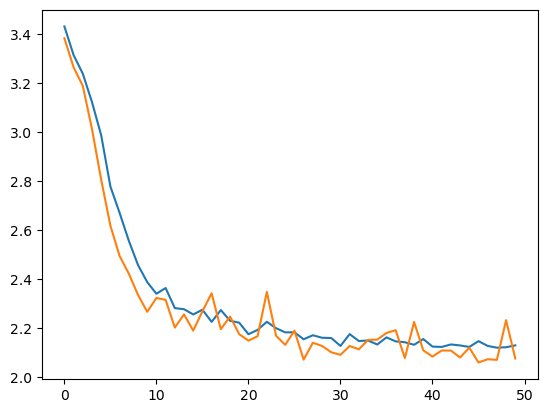

In [ ]:
from matplotlib import pyplot as plt

## [ TODO ]
# 1) Plot the loss of the model during training for both training set and validation set.
#    (Hint: for history list of dicts, training loss is `history[epoch]["loss_train"]` and `history[epoch]["loss_vali"]`)
epochs = range(len(history_basic))
losses_train = [history_basic[e]['loss_train'] for e in epochs]
plt.plot(epochs, losses_train)

# 2) Plot the accuracy of the model during training for both training set and validation set.
#    (Hint: for history list of dicts, training accuracy is `history[epoch]["acc_train"]` and `history[epoch]["acc_vali"]`)
#    (Note: plot all curves for the same metric on the same graph for comparison)
losses_vali = [history_basic[e]['loss_vali'] for e in epochs]
plt.plot(epochs, losses_vali)

plt.show()

Next, we evaluate our model end-to-end on the test set. Like training and validation set, we transform test set CAPTCHA images through data augmentation. We then predict the characters for these images and compare the predictions with ground truth. Similar to lab 3, we compute the accuracy of our model and show samples of correct and incorrect predictions:

In [53]:
def evaluate_model(model, le, dataset_eval, batch_size=32, n_epochs=5, n_display_samples=10, device=None):
    # Detect device from model parameters if not provided
    device = device or next(iter(model.parameters())).device

    ## [ TODO ]
    # Create evaluation data loader from `dataset_eval`
    # (Note: set the batch size)
    loader_eval = DataLoader(dataset_eval, batch_size=32)

    # Number of test samples and correct predictions
    n_test = n_correct = 0
    # Correct and incorrect samples
    correct_samples = []
    incorrect_samples = []

    # Put model in validation mode
    model.eval()

    for i in range(n_epochs):
        # In every epoch, do training first ...
        print(f"Starting evaluation epoch {i+1}/{n_epochs} ...")
        for images_batch, texts_batch in tqdm(loader_eval):
            # Make a copy of images batch on target PyTorch device, while keeping original batch on CPU
            images_batch_device = images_batch.to(device)

            ## [ TODO ]
            # 1) Predict characters with neural network model
            prediction = model(images_batch_device)
            prediction = torch.argmax(prediction, dim=2)
            print(prediction.shape)

            # 2) Flatten and move predictions to CPU
            class_indices_pred = prediction.flatten(0, 1).detach().to('cpu')
            print(class_indices_pred.shape)

            # 3) Decode predicted class indices back to characters using `LabelEncoder.inverse_transform`
            chars_pred = le.inverse_transform(class_indices_pred)

            # 4) Group every 4 characters together to form predicted CAPTCHAs
            #    (Hint: `hw2_util.group_every` can help with grouping)
            captchas_pred = [''.join(group) for group in hw2_util.group_every(chars_pred, 4)]

            # 5) For each CAPTCHA, its prediction and actual text:
            #    - Update number of correct predictions
            #    - Collect `n_display_samples` correct samples of tuple (image, prediction) for review
            #    - Collect `n_display_samples` incorrect samples of tuple (image, prediction, actual) for review
            #      (Caution: DO NOT print ALL correct / incorrect images; this is slow and the output will be messy!)
            for i in range(len(images_batch)):
                n_test += 1
                if captchas_pred[i] == texts_batch[i]:
                    n_correct += 1
                    if len(correct_samples) < n_display_samples:
                        correct_samples.append((images_batch[i][0], captchas_pred[i]))
                else:
                    if len(incorrect_samples) < n_display_samples:
                        incorrect_samples.append((images_batch[i][0], captchas_pred[i], texts_batch[i]))

        # Report loss and metrics
        print(f"Ending evaluation of epoch {i+1}/{n_epochs} ...")

    # Put model back in training mode
    model.train()

    # Show statistics
    print()
    print("# of test CAPTCHAs:", n_test)
    print("# correctly recognized:", n_correct)
    print("Accuracy:", n_correct/n_test, "\n")

    assert len(correct_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} correct samples as examples!"
    assert len(incorrect_samples)<=n_display_samples, \
        f"you should only display {n_display_samples} incorrect samples as examples!"

    # Show all correct predictions
    hw2_util.print_images(
        hw2_util.unzip(correct_samples)[0],
        texts=[f"Correct: {actual}" for _, actual in correct_samples],
        n_rows=2
    )

    # Show all incorrect predictions
    hw2_util.print_images(
        hw2_util.unzip(incorrect_samples)[0],
        texts=[
            f"Prediction: {pred}\nActual: {actual}" \
            for _, pred, actual in incorrect_samples
        ],
        n_rows=2,
        fig_size=(20, 6),
        text_center=(0.5, -0.25)
    )

Now we run the evaluation process on the basic model:

Starting evaluation epoch 1/5 ...


100%|██████████| 8/8 [00:00<00:00, 93.91it/s]


torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([4, 4])
torch.Size([16])
Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 2/5 ...


100%|██████████| 8/8 [00:00<00:00, 98.97it/s]


torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([4, 4])
torch.Size([16])
Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 3/5 ...


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])


100%|██████████| 8/8 [00:00<00:00, 95.30it/s]


torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([4, 4])
torch.Size([16])
Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 4/5 ...


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])


100%|██████████| 8/8 [00:00<00:00, 92.21it/s]


torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([4, 4])
torch.Size([16])
Ending evaluation of epoch 4/5 ...
Starting evaluation epoch 5/5 ...


  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])


100%|██████████| 8/8 [00:00<00:00, 94.50it/s]

torch.Size([32, 4])
torch.Size([128])
torch.Size([32, 4])
torch.Size([128])
torch.Size([4, 4])
torch.Size([16])
Ending evaluation of epoch 4/5 ...

# of test CAPTCHAs: 1140
# correctly recognized: 10
Accuracy: 0.008771929824561403 



Figure(2000x500)
Figure(2000x600)


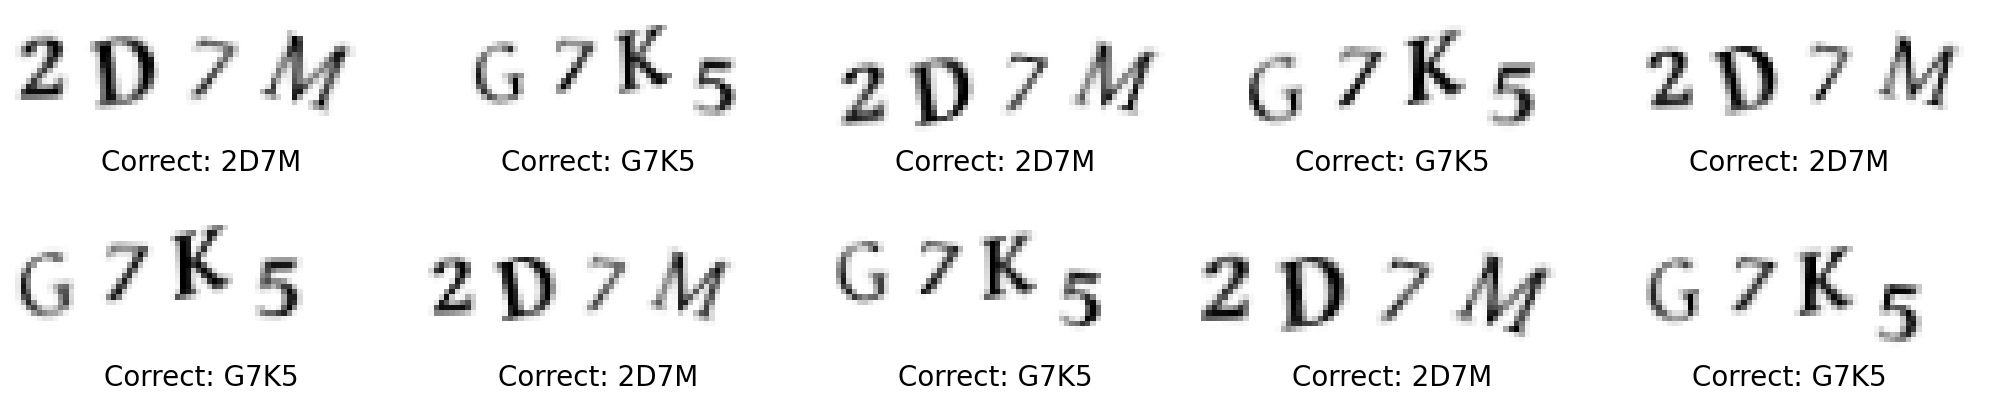

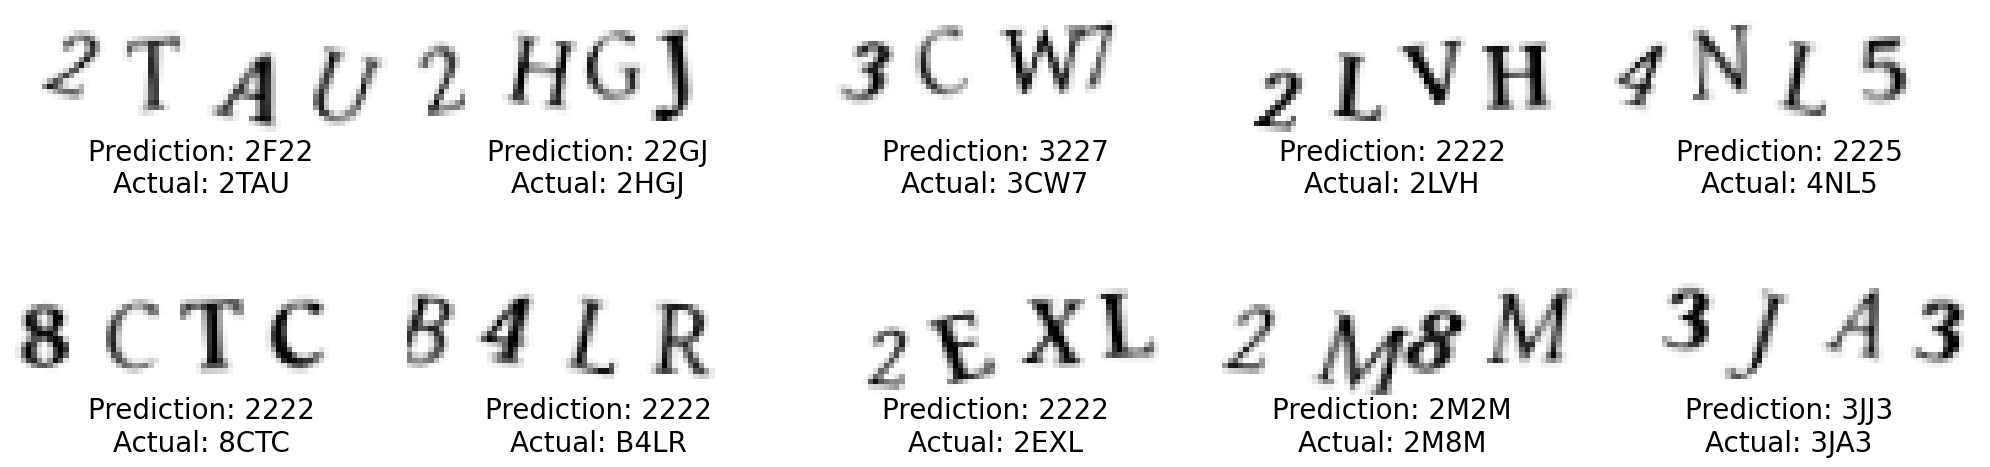

In [54]:
# Build evaluation dataset
dataset_eval = CAPTCHADataset(captcha_images_test, captcha_texts_test, captcha_transform)

# Evaluate the basic model
evaluate_model(model_basic, le, dataset_eval)

## Questions

1. What is the purpose and benefits of data augmentation?


The purpose of data augmentation is to avoid repeating the exact same training data (identical location/rotation/&c. details) so that it must learn more general patterns. This helps reduce overfitting without collecting completely new training data.

2. What is the purpose of 1\*1 convolution kernel?
   

The 1*1 convolution kernel is used to avoid further mutating the data as it is reduced from 800 nodes to the final prediction size.

3. What is the purpose of dropout? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

The purpose of dropout is to improve generalization by reducing overfitting. Removing certain neurons rewards redundant prediction pathways, which discourages overfitted solutions that happen to fit the training data but aren't coded 'efficiently'. This question is somewhat philosophical here as the assignment hasn't asked for dropout so far (unless I am super blind) but it probably wouldn't help much here because training performance is very low.

4. What is the purpose of batch normalization? Does it work on improving the convergence of training or on generalization? Give some reasons to support your idea.

Batch normalization is supposed to stabilize training and improve performance. It seems more likely to improve convergence of training, since it doesn't (significantly) reduce the complexity of model (it looks like it should remove 2 degrees of freedom from each layer, which is not a big difference compared to the expected size of model layers). Standardizing weights may help prevent them from exploding toward zero or infinity, which might help prevent the floating-point arithmetic (or whatever PyTorch is using under the hood) from going berserk. This probably allows gradient descent to more smoothly find solutions.

## Improvements (Optional; Not Graded)

Like homework 1, **you can optionally choose to work on two improvements to the neural network model**, and see if these modifications help with the accuracy. Please note that we won't grade your solutions for these questions, but we may give you feedbacks should you choose to complete them. We also encourage you to **reuse previous code and functions** as much as possible, and avoid repeating identicial code from previous part of this homework.

***

   Neural network models are susceptible to over-fitting problems due to their huge amount of free parameters. When neural network model overfits, it performs extremely well on the training set, but can easily fail when new samples are added. There are three possible approaches to mitigate the over-fitting issue:

  * Adding regularization (L1 and/or L2) to parameters of each linear or convolution layer.
  * Adding dropout layers (`torch.nn.Dropout`) to the model.
  * Adding batch normalization layers (`torch.nn.BatchNorm2d`) to the model.
  
Try one or a few of these approaches and compare their performance with the original model. Complete the following tasks by adding code and text cells  above and compare their performance with the original model. Complete the following tasks by adding code and text cells below:
  
  * Specify your choice of approaches and the details for each approach:
    - For regularization, this is the type of regularization and regularization factor for each convolution and linear layer.
    - For dropout layers, specify the number, position and dropout rate of all dropout layers.
    - For batch normalization layers, specify the number and position of all batch normalization layers.
  * Plot the loss and accuracy for both training and validation set. Think about what curves to put on the same plot.
    - One idea is to put the same metric of all four models (basic model and three improvement models) for the same set (e.g. training set) on the same plot. In this case, you will get four plots in the end.
    - You don't need to include plots as images in the notebook. Instead, just provide the code that can plot these curves.
  * Finally, report the accuracy of all three improvement models on the test set.

## Submission

When you’re done, push this completed notebook (including all code and discussion answers) to your GitHub repo, then submit the repo link on the Canvas submission page.


## References

1. PyTorch API reference: https://pytorch.org/docs/stable/index.html
2. PyTorch Neural Network Modules: https://pytorch.org/docs/stable/nn.html
3. Over-fitting: https://en.wikipedia.org/wiki/Overfitting
4. Residual neural network: https://en.wikipedia.org/wiki/Residual_neural_network
5. Residual blocks - Building blocks of ResNet: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec